In [1]:
%matplotlib notebook
import numpy as np
import os
from scipy.integrate import ode
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from modules_ajuste import lee_archivo_CIN, salto_instantaneo_espacial, deteccion_borde


import sys
sys.path.append("/home/pablo/CinePy")
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA3 as REACTOR
from modules.point_kinetics.reactimeter import reactimetro

# Solución de la cinética puntual para un salto en escalón

In [2]:
# Se leen juego de cosntantes nucleares de neutrones retardados
b, lam , beta = lee_constantes_retardados('Tuttle')

# Se leen constantes características de cada reactor
Lambda_red = REACTOR.LAMBDA_REDUCIDO

constantes_cineticas = b, lam, Lambda_red

In [3]:
# Tiempo máximo de la integración
tmax = 90
# Cantidad de puntos
Npunt = 10000
# Vector temporal (para odeint)
t = np.linspace(0.0, tmax, Npunt)
# Paso de integración (para ode)
dt = t[1]-t[0]
print('Resolución temporal : {:.4e}'.format(dt))

Resolución temporal : 9.0009e-03


## Solución analítica de un salto en escalón de reactividad

Para un reactor inicialmente crítico y estacionario en un valor $n_0$ (sin fuente externa de neutrones), a un tiempo $t_0$ se produce un cambio de reactividad $\$_0$ de forma instantánea.

La solución exacta de esta evolución es:

\begin{align}
n(t < t_0 ) &= 1 \\
n(t\ge t_0) &= A_1 \sum_{i=1}^7 B_i e^{\omega_i (t-t_0)} + A_3
\end{align}


donde los coeficientes $B_i$ se definen como:

\begin{equation}
B_i = \frac{\$_0 / \omega_i}{\Lambda^*  + \sum_{j=1}^6 \frac{b_j\lambda_j}{(\omega_i + \lambda_j)^2}}
\end{equation}

y los $\omega_i$ son las soluciones de la ecuación in-hour:

\begin{equation}
\$_0 = \Lambda^* \omega + \omega \sum_{i=1}^6 \frac{b_i}{\omega + \lambda_i}
\end{equation}

### Definición de parámetros:

In [4]:
# Cambio en reactividad (en dólares)
rho = -1   
# Tiempo del salto instantáneo
t0 = 2
# Valor inicial
n0 = 1

### Solución:

In [5]:
# Encuentro la solución analítica
n_analitica = salto_instantaneo_espacial(t, rho, t0, n0, 0.8, 0, constantes_cineticas)

# Graficación
fig, ax = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax[0].plot(t, n_analitica, '.-', label='Analítica') 
ax[0].set_yscale('linear')
ax[0].set_ylabel('n(t)')
ax[0].legend()

reactividad = rho * np.ones_like(t)
reactividad[t<t0] = 0.0
ax[1].plot(t, reactividad, '.-')
ax[1].set_ylabel(r'$\$$(t)')
ax[1].set_xlabel('Tiempo [s]')

fig.tight_layout()

<IPython.core.display.Javascript object>

## Ajuste del modelo


In [6]:
from lmfit import Minimizer, Parameters, report_fit
from scipy.stats import norm

def invertir_orden_leyenda(ax, loc='best'):
    """ Necesario por bug en plt.errorbar"""
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')

Primero genero la señal que voy a ajustar y le agrego ruido Gaussiano

In [7]:
# Parámetros que voy a simular
param_sim = {'rho':-10, 't1':2, 'n0':1, 'A1':0.8, 'A3':0.01, 'constantes':constantes_cineticas}

# Solución analítica
n_analitica = salto_instantaneo_espacial(t, **param_sim)

# Amplitud del ruido
amp_ruid = 0.0001 * n0
# Ruido Gaussiano
n_ruid = amp_ruid * np.random.normal(size=n_analitica.shape )
# Funcón simulada
n_sim = n_analitica + n_ruid

# Graficación
fig, ax = plt.subplots(1,1)
ax.plot(t, n_sim, label='Simulada')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('n(t)')
ax.legend();

<IPython.core.display.Javascript object>

## Ajuste usando función analítica como modelo

In [13]:
# Defino la función objetivo

def residual_analitico(params, t, data=None, sigma=None, constantes=None):
    parvals = params.valuesdict()
    rho = parvals['rho']
    t0 = parvals['t1']
    n0 = parvals['n0']
    A1 = parvals['A1']
    A3 = parvals['A3']

    model = salto_instantaneo_espacial(t, rho, t0, n0, A1, A3, constantes) 

    if data is None:
        return model
    if sigma is None:
        return model - data
    return (model - data) / sigma

In [14]:
# Parametros iniciales
param_ini = -1, 1, 1, 1, 0

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0])
params.add('t1', value=param_ini[1])
params.add('n0', value=param_ini[2], vary=False)
params.add('A1', value=param_ini[3])
params.add('A3', value=param_ini[4])

# Selección del intervalo de ajuste
ind_fit = (t>=t0+6) & (t<=80)
t_fit = t[ind_fit]
n_sim_fit = n_sim[ind_fit]
# Se define la minimización
minner = Minimizer(residual_analitico, params,
                   fcn_args=(t_fit,),
                   fcn_kws={'data': n_sim_fit, 'sigma': amp_ruid, 'constantes': constantes_cineticas}
                   ) 

In [15]:
# Se realiza la minimización de la función objetivo
# metodos = 'nelder', 'leastsq'
metodos = 'leastsq',
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results]

print("Simulados \t\t\t\t Ajustados")
for nam in results[-1].var_names:
    print("{} \t\t {}".format(param_sim[nam], results[-1].params[nam]))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 212
    # data points      = 8000
    # variables        = 4
    chi-square         = 7993.56915
    reduced chi-square = 0.99969599
    Akaike info crit   = 1.56656193
    Bayesian info crit = 29.5153492
[[Variables]]
    rho: -12.3850694 +/- 2.52618848 (20.40%) (init = -1)
    t1:   1.91650345 +/- 0.07099741 (3.70%) (init = 1)
    n0:   1 (fixed)
    A1:   0.99445551 +/- 0.20579903 (20.69%) (init = 1)
    A3:   0.01001565 +/- 1.5971e-05 (0.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, A1) = -1.000
    C(t1, A1)  = -0.995
    C(rho, t1) =  0.994
    C(rho, A3) = -0.984
    C(A1, A3)  =  0.983
    C(t1, A3)  = -0.964
Simulados 				 Ajustados
-10 		 <Parameter 'rho', value=-12.385069433510303 +/- 2.53, bounds=[-inf:inf]>
2 		 <Parameter 't1', value=1.9165034546633544 +/- 0.071, bounds=[-inf:inf]>
0.8 		 <Parameter 'A1', value=0.9944555051208646 +/- 0.206, bounds=[-inf:inf]>
0

<IPython.core.display.Javascript object>


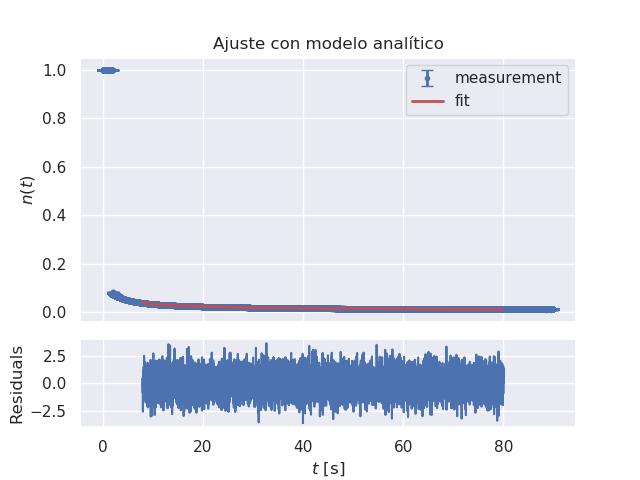

<IPython.core.display.Javascript object>


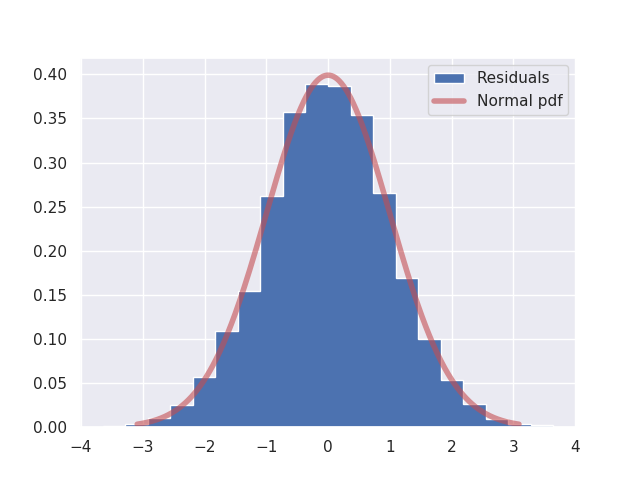

In [16]:
result = results[0]
best_fit = n_sim_fit + result.residual * amp_ruid

fig, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t, n_sim, yerr=n_ruid, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t_fit, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo analítico')

# Gráfico de residuos
ax1.plot(t_fit, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)

# Graficación del histograma de los residuos
fig2, ax3 = plt.subplots(1, 1)
ax3.hist(result.residual, bins=20, density=True, label='Residuals',
         histtype='stepfilled')
res_mean = np.mean(result.residual)
res_std = np.std(result.residual, ddof=1)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 500)
# Agrego la pdf de una Gaussiana con valor medio y desvío obtenido de los residuos
ax3.plot(x, norm.pdf(x, loc=res_mean, scale=res_std),
         'r-', lw=4, alpha=0.6, label='Normal pdf')

[invertir_orden_leyenda(ax) for ax in (ax0, ax3)];

# Ajuste de datos medidos

<IPython.core.display.Javascript object>


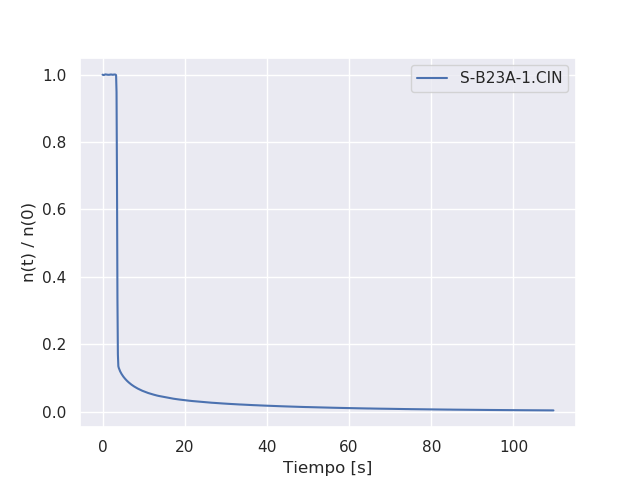

In [17]:
folder = "data"
archivo = "S-B23A-1.CIN"
#archivo = "S-B23A-2.CIN"
#archivo = "SCT-13-1.CIN"
#archivo = "SCT-13-2.CIN"
file_path = os.path.join(folder, archivo)

t_cin, n_cin = lee_archivo_CIN(file_path)

# Normalizo con el promedio de los primeros 2s
n_cin_nor = n_cin / np.mean(n_cin[t_cin<=2])

fig5, ax5 = plt.subplots(1)
ax5.plot(t_cin, n_cin_nor, label=archivo)
ax5.set_xlabel(r'Tiempo [s]')
ax5.set_ylabel(r'n(t) / n(0)')
ax5.legend()
plt.show()

In [18]:
t_cero = deteccion_borde(t_cin, n_cin, (0.1,3), 'bajada', 3.5)
print(t_cero)

3.295431


In [21]:
# Parametros iniciales
param_ini = -2, 1, 1, 1, 0

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0])
params.add('t1', value=param_ini[1])
params.add('n0', value=param_ini[2], vary=False)
params.add('A1', value=param_ini[3])
params.add('A3', value=param_ini[4])

# Selección del intervalo de ajuste

ind_fit = (t_cin>=t_cero+6) & (t_cin<=t_cero+79)
t_fit = t_cin[ind_fit]
n_cin_fit = n_cin_nor[ind_fit]
# Se define la minimización
minner = Minimizer(residual_analitico, params,
                   fcn_args=(t_fit,),
                   fcn_kws={'data': n_cin_fit, 'constantes': constantes_cineticas},
                   ) 


# Se realiza la minimización de la función objetivo
# metodos = 'nelder', 'leastsq'
metodos = 'leastsq',
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results]
print(80*'-')
print("Archivo analizado: {}".format(archivo))
!cat data/resultados_fercin4.txt

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 665
    # variables        = 4
    chi-square         = 8.3367e-07
    reduced chi-square = 1.2612e-09
    Akaike info crit   = -13622.6499
    Bayesian info crit = -13604.6508
[[Variables]]
    rho: -4.88597096 +/- 0.21644332 (4.43%) (init = -2)
    t1:   3.42701037 +/- 0.04304045 (1.26%) (init = 1)
    n0:   1 (fixed)
    A1:   0.87300098 +/- 0.03993247 (4.57%) (init = 1)
    A3:  -1.1732e-05 +/- 2.0538e-05 (175.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, A1) = -1.000
    C(t1, A1)  = -0.995
    C(rho, t1) =  0.995
    C(rho, A3) = -0.984
    C(A1, A3)  =  0.983
    C(t1, A3)  = -0.966
--------------------------------------------------------------------------------
Archivo analizado: S-B23A-1.CIN

archivo       t_0     t_b       A3        $m       $i     $d        $p         EE

S-B23A-1     3.295    0.28    -0.79e-4   4.25(2)   5.63    5.94  

<IPython.core.display.Javascript object>


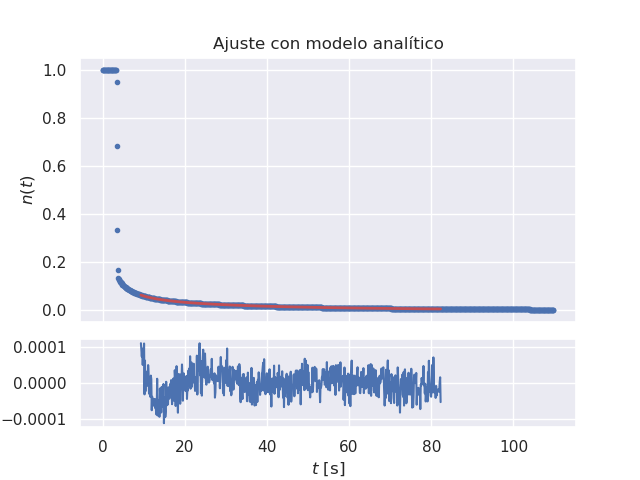

<IPython.core.display.Javascript object>


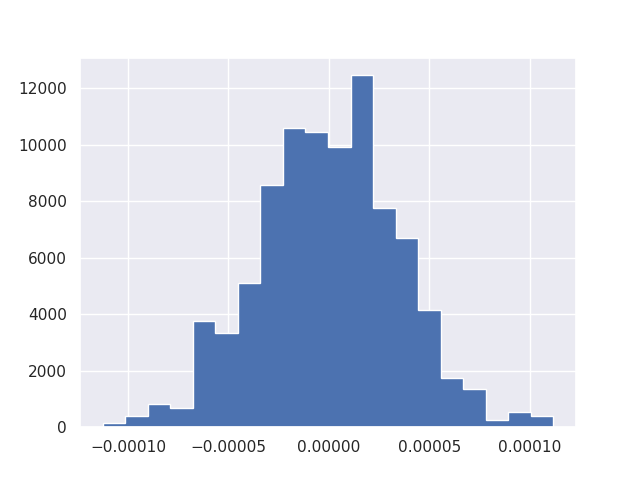

In [22]:
result = results[-1]
best_fit = n_cin_fit + result.residual 

fig, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t_cin, n_cin_nor, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t_fit, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo analítico')

# Gráfico de residuos
ax1.plot(t_fit, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)

# Graficación del histograma de los residuos
fig2, ax3 = plt.subplots(1, 1)
ax3.hist(result.residual, bins=20, density=True, label='Residuals',
         histtype='stepfilled')
res_mean = np.mean(result.residual)
res_std = np.std(result.residual, ddof=1)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 500)

# Ajuste con cinética puntual 

In [25]:
# Parametros iniciales
param_ini = -2, 1, 1, 1, 0

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0])
params.add('t1', value=param_ini[1])
params.add('n0', value=param_ini[2], vary=False)
params.add('A1', value=param_ini[3], vary=False)
params.add('A3', value=param_ini[4])

# Selección del intervalo de ajuste

ind_fit = (t_cin>=t_cero+6) & (t_cin<=t_cero+80)
t_fit = t_cin[ind_fit]
n_cin_fit = n_cin_nor[ind_fit]
# Se define la minimización
minner = Minimizer(residual_analitico, params,
                   fcn_args=(t_fit,),
                   fcn_kws={'data': n_cin_fit, 'constantes': constantes_cineticas},
                   ) 


# Se realiza la minimización de la función objetivo
# metodos = 'nelder', 'leastsq'
metodos = 'leastsq',
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results]
print(80*'-')
print("Archivo analizado: {}".format(archivo))
print(r"t_b = {}".format(results[-1].params['t1'] - t_cero))
!cat data/resultados_fercin4.txt

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 674
    # variables        = 3
    chi-square         = 8.4850e-07
    reduced chi-square = 1.2645e-09
    Akaike info crit   = -13806.2960
    Bayesian info crit = -13792.7563
[[Variables]]
    rho: -5.57393615 +/- 0.00179544 (0.03%) (init = -2)
    t1:   3.30855222 +/- 0.00413899 (0.13%) (init = 1)
    n0:   1 (fixed)
    A1:   1 (fixed)
    A3:   4.4370e-05 +/- 3.6479e-06 (8.22%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, t1) = -0.943
    C(rho, A3) = -0.878
    C(t1, A3)  =  0.729
--------------------------------------------------------------------------------
Archivo analizado: S-B23A-1.CIN
t_b = 0.01312121646436859

archivo       t_0     t_b       A3        $m       $i     $d        $p         EE

S-B23A-1     3.295    0.28    -0.79e-4   4.25(2)   5.63    5.94    5.524(6)    30.1
S-B23A-2     3.295    0.27     0.11e-2   4.24(2)   4.46    4.50 

<IPython.core.display.Javascript object>


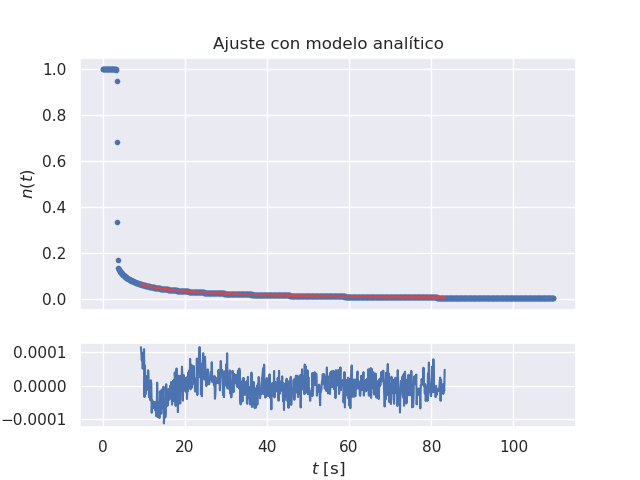

In [26]:
result = results[-1]
best_fit = n_cin_fit + result.residual 

fig3, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t_cin, n_cin_nor, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t_fit, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo analítico')

# Gráfico de residuos
ax1.plot(t_fit, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)
